In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="code."></form>''')

# Introducción

En presente trabajo se analizaron los resultados productivos de una empresa productora de pollos parrilleros para detectar las variables que impactan sobre los resultados y realizar recomendaciones a partir de ello. En segunda instancia se construyó un modelo de regresión 

## Obtención de base de datos

In [ ]:
# Se presentan las librerías utilizadas:
import pandas as pd
import xlsxwriter
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import numpy as np
import datetime
import statsmodels.api as sm
from scipy import stats
import requests
import json
import plotly.express as px
import ydata_profiling
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing


In [ ]:
#Ingresos semanales compilado registra resultados finales de la producción en la pestaña BASE. Contiene además datos de genética, nutrición y sanidad.
df = pd.read_excel(r"C:\Users\ebover\OneDrive - FRIGORIFICO DE AVES SOYCHU S.A.I.C.F.I.A\ingresos semanales compilado.xlsx",sheet_name='BASE', skiprows=1 , usecols=range(1,67))

## Feature extraction preliminar

In [ ]:
df.drop(df[(df['A.D.'] >100)].index, inplace=True) #Se eliminan valores erróneos
df.drop(df[(df['Edad'] >70)].index, inplace=True) #Se elimninan edades fuera de estándar
df.drop(df[(df['Destino'] =='EXP')].index, inplace=True) # se eliminan crianzas de pollos enviados a exportación


In [ ]:
#subset para modelo
dfm=df[['granja','Cantid. BB','% a 7 Días','% Mortan.','A.D.','Edad','mes levante','Consumo medio diario (g)','Estación del año','Densidad','Ventilación forzada','Ambiente controlado','localidad', '% desvío consumo std','zona climática','Pes conv 2,7','zona prod' ]]
dfm.head()

# Encoding

## Transformaciones categóricas

In [ ]:
label_encoder = preprocessing.LabelEncoder()
dfm['Estación del año']= label_encoder.fit_transform(dfm['Estación del año'])
dfm['Estación del año'].unique()


label_encoder = preprocessing.LabelEncoder()
dfm['Ambiente controlado']= label_encoder.fit_transform(dfm['Ambiente controlado'])
dfm['Ambiente controlado'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm['localidad']= label_encoder.fit_transform(dfm['localidad'])
dfm['localidad'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm['zona climática']= label_encoder.fit_transform(dfm['zona climática'])
dfm['zona climática'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm['zona prod']= label_encoder.fit_transform(dfm['zona prod'])
dfm['zona prod'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm['Ventilación forzada']= label_encoder.fit_transform(dfm['Ventilación forzada'])
dfm['Ventilación forzada'].unique()



# Feature selection

## Exploratory Data Analysis


In [ ]:
# Gráfico 1
sns.regplot(data=dfm, x = 'Consumo medio diario (g)', y = 'A.D.',
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"},
            ci = 99);

In [ ]:
np.corrcoef(dfm['Consumo medio diario (g)'], dfm['A.D.'])

Existe una mediana a alta correlación (64%) entre el consumo de alimento y la ganancia de peso, debido a ello se analizará la variable consumo como variable dependiente del modelo a aplicar.

In [ ]:
#Gráfico 2
ax=sns.boxplot(data=dfm, y='Consumo medio diario (g)') 
ax.set(title='Consumo medio diario');



Se observa una gran cantidad de valores outliers para la variable consumo por lo se generarán dos subsets para analizarlos por separado: 
dfmwo= Base de datos sin valores outliers
dfmout= Base de datos compuesta únicamente por valores outliers

In [ ]:
dfmo=dfm

In [ ]:
for x in ['Consumo medio diario (g)']:
    q75,q25 = np.percentile(dfmo.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    dfmo.loc[dfmo[x] < min,x] = np.nan
    dfmo.loc[dfmo[x] > max,x] = np.nan

In [ ]:
dfmwo = dfmo.dropna(axis = 0)

In [ ]:
for x in ['A.D.']:
    q75,q25 = np.percentile(dfmo.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    dfmo.loc[dfmo[x] < min,x] = np.nan
    dfmo.loc[dfmo[x] > max,x] = np.nan

In [ ]:
# Gráfico 4
sns.regplot(data=dfmwo, x = 'Consumo medio diario (g)', y = 'A.D.',
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"},
            ci = 99);

In [ ]:
dfmwo = dfmo.dropna(axis = 0)

In [ ]:
np.corrcoef(dfmwo['Consumo medio diario (g)'], dfmwo['A.D.'])

La correlación entre los valores de consumo y ganancia media diaria de peso no se modificó (63.7%) luego de la extracción de los valores outliers de la base de datos.

In [ ]:
dfmwo.shape

In [ ]:
# se crea un subset conformado por los valores outliers:
dfm2=df[['granja','Cantid. BB','% a 7 Días','% Mortan.','A.D.','Edad','mes levante','Consumo medio diario (g)','Estación del año','Densidad','Ventilación forzada','Ambiente controlado','localidad', '% desvío consumo std','zona climática','Pes conv 2,7','zona prod' ]]
dfm2.head()

In [ ]:
label_encoder = preprocessing.LabelEncoder()
dfm2['Estación del año']= label_encoder.fit_transform(dfm2['Estación del año'])
dfm2['Estación del año'].unique()


label_encoder = preprocessing.LabelEncoder()
dfm2['Ambiente controlado']= label_encoder.fit_transform(dfm2['Ambiente controlado'])
dfm2['Ambiente controlado'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm2['localidad']= label_encoder.fit_transform(dfm2['localidad'])
dfm2['localidad'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm2['zona climática']= label_encoder.fit_transform(dfm2['zona climática'])
dfm2['zona climática'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm2['zona prod']= label_encoder.fit_transform(dfm2['zona prod'])
dfm2['zona prod'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm2['Ventilación forzada']= label_encoder.fit_transform(dfm2['Ventilación forzada'])
dfm2['Ventilación forzada'].unique()

In [ ]:
dfmout=dfm2

In [ ]:
dfmout.drop(dfmout[(dfmout['A.D.'] >47.15) & (dfmout['A.D.'] <68.55)].index, inplace=True) 
dfmout.drop(dfmout[(dfmout['Consumo medio diario (g)'] >99.2) & (dfmout['Consumo medio diario (g)'] <196.05)].index, inplace=True)


In [ ]:
#Gráfico 5
corr = dfmwo.corr('pearson')
target_corr = corr['Consumo medio diario (g)'].values.reshape(-1,1)

sns.heatmap(target_corr, annot=True, yticklabels= dfmwo.columns, cmap='coolwarm')
plt.title('Mapa de calor de correlación con variable destino')
plt.show()


In [ ]:
# Gráfico 6
corr = dfmout.corr('pearson')
target_corr = corr['Consumo medio diario (g)'].values.reshape(-1,1)

sns.heatmap(target_corr, annot=True, yticklabels= dfmout.columns, cmap='coolwarm')
plt.title('Mapa de calor de correlación con variable destino outliers')
plt.show()

Del análisis de los mapas de calor se desprende que las correlaciones entre el consumo y el resto de las variables analizadas son altas para la ganancia de peso y para el desvío del consumo de alimento respecto del estándar (dependiente). Para el caso del grupo de valores outliers ocurre lo mismo.

# Entrenamiento modelos machine learning

# RandomForestClassifier

Se confeccionó un modelo de clasificación para predecir la zona climática de producción en función de los valores del resto de las variables de la base.

In [ ]:
# Seleccionar las variables predictoras y la variable de destino
X = dfmwo.drop('zona climática', 1) 
y = dfmwo['zona climática']

In [ ]:
# Dividir el conjunto de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

In [ ]:
# Obtener predicciones
y_pred= clf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred=y_pred, y_true= y_test))

In [ ]:
clf.feature_importances_

In [ ]:
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

La precisión promedio alcanzada fue del 86%, lo que indica que el modelo fue capaz de clasificar correctamente la mayoría de las muestras. El modelo mostró una alta precisión para todas las clases; mientras que la clase 2 tuvo una precisión perfecta, su recall y f1-score fueron bajos. Esto sugiere que el modelo tuvo dificultades para clasificar correctamente esta clase.

## Base de datos sin outliers

# Linear regression

In [ ]:
from sklearn.model_selection import train_test_split

X1=dfmwo.drop(['Consumo medio diario (g)','Pes conv 2,7'], 1) 

y1=dfmwo['Consumo medio diario (g)']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression


In [ ]:
model = LinearRegression(fit_intercept=True)
model.fit(X1, y1)
y1_train_pred = model.predict(X1_train)
y1_test_pred = model.predict(X1_test)


In [ ]:
print('Error en datos de train:', mean_squared_error(y1_train, y1_train_pred))
print('Error en datos de test:', mean_squared_error(y1_test, y1_test_pred))

lr_test_mse = mean_squared_error(y1_test, y1_test_pred)
lr_train_mse = mean_squared_error(y1_train, y1_train_pred)

In [ ]:
model.coef_

In [ ]:
coeff_df = pd.DataFrame(model.coef_, X1.columns, columns=['Coefficient']).reset_index()
coeff_df

In [ ]:
ax=sns.barplot(data=coeff_df, x='Coefficient',y='index') 
ax.bar_label(ax.containers[0])
ax.set(xlim=(-40, 40))
ax.set(title='Coeficientes de correlación');

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
k_range = range(1, 50)
scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X1_train, y1_train)
    scores.append(knn.score(X1_test, y1_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,20,30,40,50]);

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5)
model.fit(X1, y1)
y1_train_pred = model.predict(X1_train)
y1_test_pred = model.predict(X1_test)



print('Error en datos de train:', mean_squared_error(y1_train, y1_train_pred))
print('Error en datos de test:', mean_squared_error(y1_test, y1_test_pred))

knr_test_mse = mean_squared_error(y1_test, y1_test_pred)
knr_train_mse = mean_squared_error(y1_train, y1_train_pred)


# Random forest regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X1, y1)
y1_train_pred = model.predict(X1_train)
y1_test_pred = model.predict(X1_test)

In [ ]:
print('Error en datos de train:', mean_squared_error(y1_train, y1_train_pred))
print('Error en datos de test:', mean_squared_error(y1_test, y1_test_pred))

rfr_test_mse = mean_squared_error(y1_train, y1_train_pred)
rfr_train_mse = mean_squared_error(y1_test, y1_test_pred)

# Xgboost

In [ ]:
! pip install xgboost

In [ ]:
import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=50, random_state=42)
model.fit(X1, y1)
y1_train_pred = model.predict(X1_train)
y1_test_pred = model.predict(X1_test)

In [ ]:
print('Error en datos de train:', mean_squared_error(y1_train, y1_train_pred))
print('Error en datos de test:', mean_squared_error(y1_test, y1_test_pred))

xgb_test_mse = mean_squared_error(y1_train, y1_train_pred)
xgb_train_mse = mean_squared_error(y1_test, y1_test_pred)

In [ ]:
valores = [lr_train_mse, knr_train_mse, rfr_train_mse, xgb_train_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Train')
plt.title('Comparación de MSE entre modelos de regresión')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

In [ ]:
valores = [lr_test_mse, knr_test_mse, rfr_test_mse, xgb_test_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Test')
plt.title('Comparación de MSE entre modelos de regresión')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y1_test, y1_test_pred)
print("MSE:", mse)

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mse)
print("RMSE:", rmse)

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y1_test, y1_test_pred)
print("MAE:", mae)

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y1_test, y1_test_pred)
print("R^2:", r2)

## Base solo outliers

## Linear regression

In [ ]:
from sklearn.model_selection import train_test_split

X2=dfmout.drop('Consumo medio diario (g)', 1) 

y2=dfmout['Consumo medio diario (g)']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.30, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression(fit_intercept=True)
model.fit(X2, y2)
y2_train_pred = model.predict(X2_train)
y2_test_pred = model.predict(X2_test)

In [ ]:
print('Error en datos de train:', mean_squared_error(y2_train, y2_train_pred))
print('Error en datos de test:', mean_squared_error(y2_test, y2_test_pred))

lr_test_mse = mean_squared_error(y2_test, y2_test_pred)
lr_train_mse = mean_squared_error(y2_train, y2_train_pred)

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
k_range = range(1, 50)
scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X2_train, y2_train)
    scores.append(knn.score(X2_test, y2_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,20,30,40,50]);

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5)
model.fit(X2, y2)
y2_train_pred = model.predict(X2_train)
y2_test_pred = model.predict(X2_test)



print('Error en datos de train:', mean_squared_error(y2_train, y2_train_pred))
print('Error en datos de test:', mean_squared_error(y2_test, y2_test_pred))

knr_test_mse = mean_squared_error(y2_test, y2_test_pred)
knr_train_mse = mean_squared_error(y2_train, y2_train_pred)


## Random forest regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X2, y2)
y2_train_pred = model.predict(X2_train)
y2_test_pred = model.predict(X2_test)

In [ ]:
print('Error en datos de train:', mean_squared_error(y2_train, y2_train_pred))
print('Error en datos de test:', mean_squared_error(y2_test, y2_test_pred))

rfr_test_mse = mean_squared_error(y2_train, y2_train_pred)
rfr_train_mse = mean_squared_error(y2_test, y2_test_pred)

## Xgboost

In [ ]:
import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=50, random_state=42)
model.fit(X2, y2)
y2_train_pred = model.predict(X2_train)
y2_test_pred = model.predict(X2_test)

In [ ]:
print('Error en datos de train:', mean_squared_error(y2_train, y2_train_pred))
print('Error en datos de test:', mean_squared_error(y2_test, y2_test_pred))

xgb_test_mse = mean_squared_error(y2_train, y2_train_pred)
xgb_train_mse = mean_squared_error(y2_test, y2_test_pred)

In [ ]:
valores = [lr_train_mse, knr_train_mse, rfr_train_mse, xgb_train_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Train')
plt.title('Comparación de MSE entre modelos de regresión')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

In [ ]:
valores = [lr_test_mse, knr_test_mse, rfr_test_mse, xgb_test_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Test')
plt.title('Comparación de MSE entre modelos de regresión')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y2_test, y2_test_pred)
print("MSE:", mse)

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mse)
print("RMSE:", rmse)

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y2_test, y2_test_pred)
print("MAE:", mae)

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y2_test, y2_test_pred)
print("R^2:", r2)

Tanto en los modelos de la base de datos sin outliers y la de los outliers tienen buenos valores de MSE con excepción de KNN.

# Modelos con base completa

In [ ]:
dfn=df[['granja','Cantid. BB','% a 7 Días','% Mortan.','A.D.','Edad','mes levante','Consumo medio diario (g)','Estación del año','Densidad','Ventilación forzada','Ambiente controlado','localidad', '% desvío consumo std','zona climática','Pes conv 2,7','zona prod' ]]
dfn.head()

In [ ]:
label_encoder = preprocessing.LabelEncoder()
dfn['Estación del año']= label_encoder.fit_transform(dfn['Estación del año'])
dfn['Estación del año'].unique()


label_encoder = preprocessing.LabelEncoder()
dfn['Ambiente controlado']= label_encoder.fit_transform(dfn['Ambiente controlado'])
dfn['Ambiente controlado'].unique()

label_encoder = preprocessing.LabelEncoder()
dfn['localidad']= label_encoder.fit_transform(dfn['localidad'])
dfn['localidad'].unique()

label_encoder = preprocessing.LabelEncoder()
dfn['zona climática']= label_encoder.fit_transform(dfn['zona climática'])
dfn['zona climática'].unique()

label_encoder = preprocessing.LabelEncoder()
dfn['zona prod']= label_encoder.fit_transform(dfn['zona prod'])
dfm['zona prod'].unique()

label_encoder = preprocessing.LabelEncoder()
dfn['Ventilación forzada']= label_encoder.fit_transform(dfn['Ventilación forzada'])
dfn['Ventilación forzada'].unique()

In [ ]:
from sklearn.model_selection import train_test_split

X3=dfn.drop('Consumo medio diario (g)', 1) 

y3=dfn['Consumo medio diario (g)']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.30, random_state=42)

## Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression


In [ ]:
model = LinearRegression(fit_intercept=True)
model.fit(X3, y3)
y3_train_pred = model.predict(X3_train)
y3_test_pred = model.predict(X3_test)


In [ ]:
print('Error en datos de train:', mean_squared_error(y3_train, y3_train_pred))
print('Error en datos de test:', mean_squared_error(y3_test, y3_test_pred))

lr_test_mse = mean_squared_error(y3_test, y3_test_pred)
lr_train_mse = mean_squared_error(y3_train, y3_train_pred)

In [ ]:
model.coef_

In [ ]:
coeff_df2 = pd.DataFrame(model.coef_, X3.columns, columns=['Coefficient']).reset_index()
coeff_df2

In [ ]:
ax=sns.barplot(data=coeff_df2, x='Coefficient',y='index') 
ax.bar_label(ax.containers[0])
ax.set(xlim=(-100, 40))
ax.set(title='Coeficientes de correlación');

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
k_range = range(1, 50)
scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X3_train, y3_train)
    scores.append(knn.score(X3_test, y3_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,20,30,40,50]);

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5)
model.fit(X3, y3)
y3_train_pred = model.predict(X3_train)
y3_test_pred = model.predict(X3_test)



print('Error en datos de train:', mean_squared_error(y3_train, y3_train_pred))
print('Error en datos de test:', mean_squared_error(y3_test, y3_test_pred))

knr_test_mse = mean_squared_error(y3_test, y3_test_pred)
knr_train_mse = mean_squared_error(y3_train, y3_train_pred)


# Random forest regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X3, y3)
y3_train_pred = model.predict(X3_train)
y3_test_pred = model.predict(X3_test)

In [ ]:
print('Error en datos de train:', mean_squared_error(y3_train, y3_train_pred))
print('Error en datos de test:', mean_squared_error(y3_test, y3_test_pred))

rfr_test_mse = mean_squared_error(y3_train, y3_train_pred)
rfr_train_mse = mean_squared_error(y3_test, y3_test_pred)

# Xgboost

In [ ]:
! pip install xgboost

In [ ]:
import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=50, random_state=42)
model.fit(X3, y3)
y3_train_pred = model.predict(X3_train)
y3_test_pred = model.predict(X3_test)

In [ ]:
print('Error en datos de train:', mean_squared_error(y3_train, y3_train_pred))
print('Error en datos de test:', mean_squared_error(y3_test, y3_test_pred))

xgb_test_mse = mean_squared_error(y3_train, y3_train_pred)
xgb_train_mse = mean_squared_error(y3_test, y3_test_pred)

In [ ]:
valores = [lr_train_mse, knr_train_mse, rfr_train_mse, xgb_train_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Train')
plt.title('Comparación de MSE entre modelos de regresión')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

In [ ]:
valores = [lr_test_mse, knr_test_mse, rfr_test_mse, xgb_test_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Test')
plt.title('Comparación de MSE entre modelos de regresión')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y3_test, y3_test_pred)
print("MSE:", mse)

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mse)
print("RMSE:", rmse)

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y3_test, y3_test_pred)
print("MAE:", mae)

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y3_test, y3_test_pred)
print("R^2:", r2)

Al igual que con las bases anteriores, utilizando los datos de la base original todos los modelos con excepción del KNN tienen valores muy bajos de MSE y elevada correlación. A continuación se realizarán pruebas con tratamientos diferentes de los datos.

## Cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
# crear el modelo
model = RandomForestRegressor(random_state=42, n_estimators=10,max_depth=4)
scores = cross_val_score(model, X3, y3, cv=7, verbose=1,scoring='r2')

In [ ]:
print("%0.2f de r2 promedio con una desviacion estandar de %0.2f" % (scores.mean(), scores.std()))

Realizando una prueba de cross validation previa a hacer correr el modelo de RandomForestRegressor el valor de correlación se redujo al 85%, por lo que disminuyó el overfitting de los modelos anteriores.

## PCA

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X3)

In [ ]:
cov_matrix = np.cov(X.T)
cov_matrix

In [ ]:
eig_values, eig_vectors = np.linalg.eig(cov_matrix)

In [ ]:
eig_vectors

In [ ]:
eig_values

In [ ]:
eig_values / eig_values.sum()

In [ ]:
idx = eig_values.argsort()[::-1]
eig_values = eig_values[idx]
eig_vectors = eig_vectors[:, idx]

In [ ]:
eig_vectors

In [ ]:
sns.scatterplot(eig_vectors);

In [ ]:
# A partir de los autovalores, calculamos la varianza explicada
tot = sum(eig_values)
var_exp = [(i / tot)*100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# Representamos en un diagrama de barras la varianza explicada por cada autovalor, y la acumulada
with plt.style.context('seaborn-pastel'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(16), var_exp, alpha=0.5, align='center',
            label='Varianza individual explicada', color='g')
    plt.step(range(16), cum_var_exp, where='mid', linestyle='--', label='Varianza explicada acumulada')
    plt.ylabel('Ratio de Varianza Explicada')
    plt.xlabel('Componentes Principales')
    plt.legend(loc='best')
    plt.tight_layout()

En el gráfico se observa que los tres primeros grupos explican la mayor parte de la varianza.

In [ ]:
W = eig_vectors[:, :3]
X_pca = X.dot(W)

In [ ]:
data_pca = pd.DataFrame(X_pca, columns = ['PC1', 'PC2','PC3'])
data_pca = pd.concat([data_pca, y3], axis = 1)
data_pca.head()

In [ ]:
data_pca.info()

In [ ]:
data_pca.isna().sum()

In [ ]:
data_pca=data_pca.dropna()

In [ ]:
X4=data_pca.drop('Consumo medio diario (g)', 1) 

y4=data_pca['Consumo medio diario (g)']

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.30, random_state=42)

In [135]:
X4.isna().sum()

PC1    0
PC2    0
PC3    0
dtype: int64

In [136]:
y4.isna().sum()

0

## Linear regression

In [139]:
model = LinearRegression(fit_intercept=True)
model.fit(X4, y4)
y4_train_pred = model.predict(X4_train)
y4_test_pred = model.predict(X4_test)


In [140]:
print('Error en datos de train:', mean_squared_error(y4_train, y4_train_pred))
print('Error en datos de test:', mean_squared_error(y4_test, y4_test_pred))

lr_test_mse = mean_squared_error(y4_test, y4_test_pred)
lr_train_mse = mean_squared_error(y4_train, y4_train_pred)

Error en datos de train: 75.6922260257605
Error en datos de test: 75.06989611986045


In [141]:
model.coef_

array([ 0.04809881, -0.17469432, -0.20888588])

In [142]:
coeff_df2 = pd.DataFrame(model.coef_, X4.columns, columns=['Coefficient']).reset_index()
coeff_df2

,index,Coefficient
0,PC1,0.048099
1,PC2,-0.174694
2,PC3,-0.208886


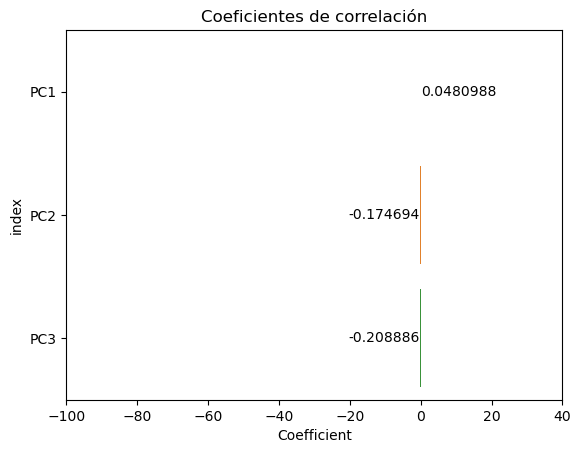

In [143]:
ax=sns.barplot(data=coeff_df2, x='Coefficient',y='index') 
ax.bar_label(ax.containers[0])
ax.set(xlim=(-100, 40))
ax.set(title='Coeficientes de correlación');

# KNN

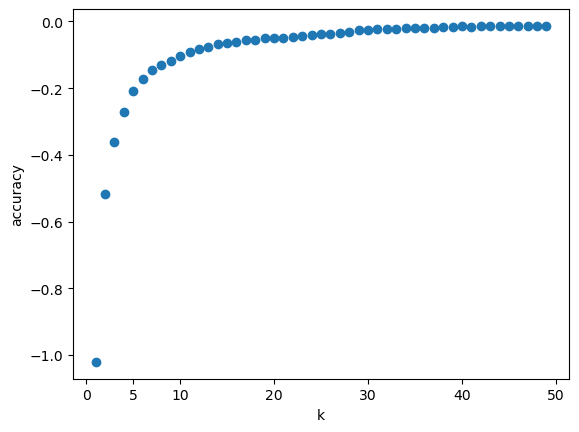

In [144]:
from sklearn.neighbors import KNeighborsRegressor
k_range = range(1, 50)
scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X4_train, y4_train)
    scores.append(knn.score(X4_test, y4_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,20,30,40,50]);

In [145]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=40)
model.fit(X4, y4)
y4_train_pred = model.predict(X4_train)
y4_test_pred = model.predict(X4_test)



print('Error en datos de train:', mean_squared_error(y4_train, y4_train_pred))
print('Error en datos de test:', mean_squared_error(y4_test, y4_test_pred))

knr_test_mse = mean_squared_error(y4_test, y4_test_pred)
knr_train_mse = mean_squared_error(y4_train, y4_train_pred)


Error en datos de train: 72.67589671631842
Error en datos de test: 71.87307945907287


# Random forest regression

In [146]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X4, y4)
y4_train_pred = model.predict(X4_train)
y4_test_pred = model.predict(X4_test)

In [147]:
print('Error en datos de train:', mean_squared_error(y4_train, y4_train_pred))
print('Error en datos de test:', mean_squared_error(y4_test, y4_test_pred))

rfr_test_mse = mean_squared_error(y4_train, y4_train_pred)
rfr_train_mse = mean_squared_error(y4_test, y4_test_pred)

Error en datos de train: 11.993211355243806
Error en datos de test: 11.801563601923005


# Xgboost

In [148]:
import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=50, random_state=42)
model.fit(X4, y4)
y4_train_pred = model.predict(X4_train)
y4_test_pred = model.predict(X4_test)

In [149]:
print('Error en datos de train:', mean_squared_error(y4_train, y4_train_pred))
print('Error en datos de test:', mean_squared_error(y4_test, y4_test_pred))

xgb_test_mse = mean_squared_error(y4_train, y4_train_pred)
xgb_train_mse = mean_squared_error(y4_test, y4_test_pred)

Error en datos de train: 61.285227852145155
Error en datos de test: 59.28369880831099


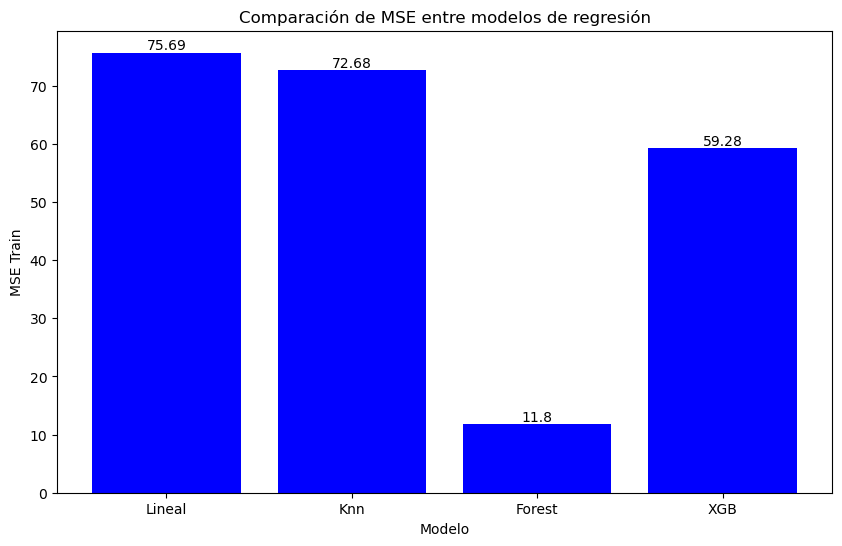

In [150]:
valores = [lr_train_mse, knr_train_mse, rfr_train_mse, xgb_train_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Train')
plt.title('Comparación de MSE entre modelos de regresión')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

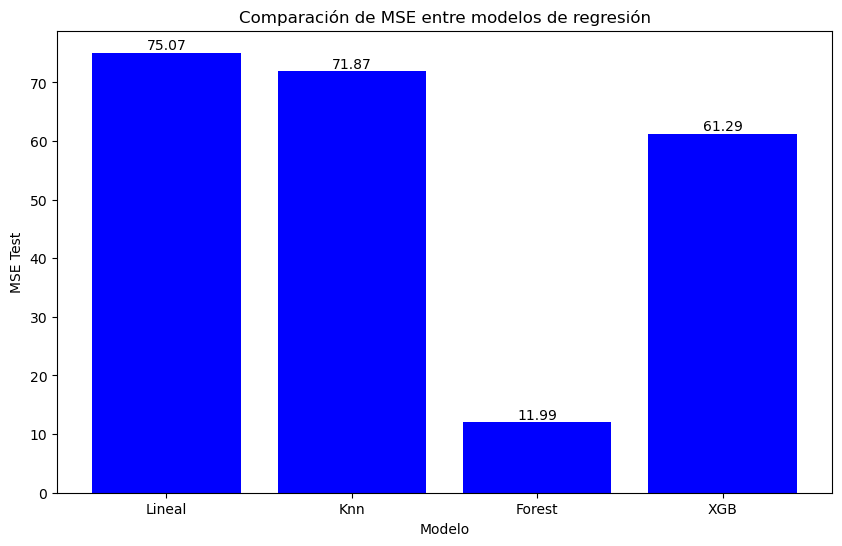

In [151]:
valores = [lr_test_mse, knr_test_mse, rfr_test_mse, xgb_test_mse]

nombres = ['Lineal', 'Knn', 'Forest', 'XGB']

plt.figure(figsize=(10, 6))
plt.bar(nombres, valores, color='blue')

plt.xlabel('Modelo')
plt.ylabel('MSE Test')
plt.title('Comparación de MSE entre modelos de regresión')

for i, value in enumerate(valores):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.show()

In [152]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y4_test, y4_test_pred)
print("MSE:", mse)

MSE: 59.28369880831099


In [153]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 7.699590820836584


In [154]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y4_test, y4_test_pred)
print("MAE:", mae)

MAE: 6.0073149470693314


In [155]:
from sklearn.metrics import r2_score
r2 = r2_score(y4_test, y4_test_pred)
print("R^2:", r2)

R^2: 0.210990514850671


Luego de reducir a 3 los componentes originales de la base todos los valores de MSE resultaron elevados con excepción de RandomForest, el coeficiente de determinación, a su vez, se redujo al 20%.